In [13]:
# Imports
import os

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# data handling
import pandas as pd
import numpy as np

# data analysis
from scipy.stats import norm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [14]:
csv_dir = 'csv/'
sids = list(set([f.split('_')[0] for f in os.listdir(csv_dir) if f.endswith('.csv')]))

unimodal_dprime = []
unimodal_beta = []

for sid in sids:
    # print(f"\n\nSubject: {sid}")
    L_file = pd.read_csv(f'{csv_dir}{sid}_L.csv')
    R_file = pd.read_csv(f'{csv_dir}{sid}_R.csv')

    combined_LR = pd.concat([L_file, R_file], axis=0)
    # print(combined_LR)

    # first get d' for unimodal detection
    # only get rows where n_beep == 0 and response == 1 (flash response)
    unimodal = combined_LR[combined_LR['response_type'] == 1]

    # Get 3 and 2 flash trials
    three_flash = unimodal[unimodal['n_flash'] == 3]
    two_flash = unimodal[unimodal['n_flash'] == 2]

    # Create copies
    three_flash_clean = three_flash.copy()
    two_flash_clean = two_flash.copy()

    # Locate accurate response and false alarms
    three_flash_clean['accuracy'] = three_flash_clean['response'] == 3
    two_flash_clean['falsealarm'] = two_flash_clean['response'] == 3

    # Calculate hit and false alarm rates
    hitrate = three_flash_clean.groupby(['blindspot', 'n_beep'])['accuracy'].mean()
    farate = two_flash_clean.groupby(['blindspot', 'n_beep'])['falsealarm'].mean()

    # Correct for extreme hitrate and farate values
    hitrate = np.clip(hitrate, 0.01, 0.99)
    farate = np.clip(farate, 0.01, 0.99)

    unimodal_dprime.append((norm.ppf(hitrate) - norm.ppf(farate)))
    unimodal_beta.append(abs(0.5*(norm.ppf(hitrate) + norm.ppf(farate))))

unimodal_dprime = np.array(unimodal_dprime)
unimodal_beta = np.array(unimodal_beta)

columns = pd.MultiIndex.from_product(
    [['Control Spot', 'Blind Spot'], ['0', '2', '3']],
    names=['blindspot', 'n_beep']
)
dprime_df = pd.DataFrame(unimodal_dprime, index=sids, columns=columns)
beta_df = pd.DataFrame(unimodal_beta, index=sids, columns=columns)

print("D': ", dprime_df.head())
print("\n\nBeta: ", beta_df.head())




D':  blindspot Control Spot                     Blind Spot                    
n_beep               0         2         3          0         2         3
SV027         0.710264  0.000000  0.683791  -0.315110  0.000000  0.494504
SV032         2.007709  0.366384  1.728588   0.000000  0.000000  0.000000
SV022         0.566297  0.245118  0.566297  -0.113916 -0.678412  0.000000
SV028         1.959964 -0.315110  0.448027   0.000000  0.000000  0.381346
SV009         0.961231  1.186184  0.448027   0.220728 -0.315110  0.355850


Beta:  blindspot Control Spot                     Blind Spot                    
n_beep               0         2         3          0         2         3
SV027         1.289721  2.326348  0.939656   1.802409  2.326348  1.397602
SV032         1.322494  2.143156  1.462054   2.326348  2.326348  2.326348
SV022         0.472267  1.158992  0.472267   1.093391  1.620758  0.385320
SV028         0.979982  1.802409  0.161307   1.281552  2.326348  0.127966
SV009         0.669734  

C:\Users\Ailene\AppData\Local\Temp\ipykernel_35360\2457711161.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = dprime_df.stack(level=['blindspot', 'n_beep']).reset_index(name='d_prime')


                     sum_sq     df          F        PR(>F)
n_beep             3.250656    2.0   8.064823  5.298224e-04
blindspot         14.980371    1.0  74.332108  4.382583e-14
n_beep:blindspot   2.755603    2.0   6.836605  1.569962e-03
Residual          22.974759  114.0        NaN           NaN

Tukey HSD for d_prime:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
  0Blind Spot 0Control Spot   1.1326    0.0  0.7211  1.5441   True
  0Blind Spot   2Blind Spot  -0.0834 0.9917 -0.4949  0.3281  False
  0Blind Spot 2Control Spot   0.4517 0.0227  0.0402  0.8632   True
  0Blind Spot   3Blind Spot   0.0379 0.9998 -0.3737  0.4494  False
  0Blind Spot 3Control Spot   0.4901 0.0099  0.0786  0.9017   True
0Control Spot   2Blind Spot   -1.216    0.0 -1.6275 -0.8045   True
0Control Spot 2Control Spot  -0.6809 0.0001 -1.0924 -0.2694   True
0Contr

C:\Users\Ailene\AppData\Local\Temp\ipykernel_35360\2457711161.py:53: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_long = beta_df.stack(level=['blindspot', 'n_beep']).reset_index(name='beta')



Tukey HSD for Beta:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      2   1.0665    0.0  0.7458  1.3872   True
     0      3   0.1531 0.4955 -0.1676  0.4738  False
     2      3  -0.9134    0.0 -1.2341 -0.5927   True
----------------------------------------------------


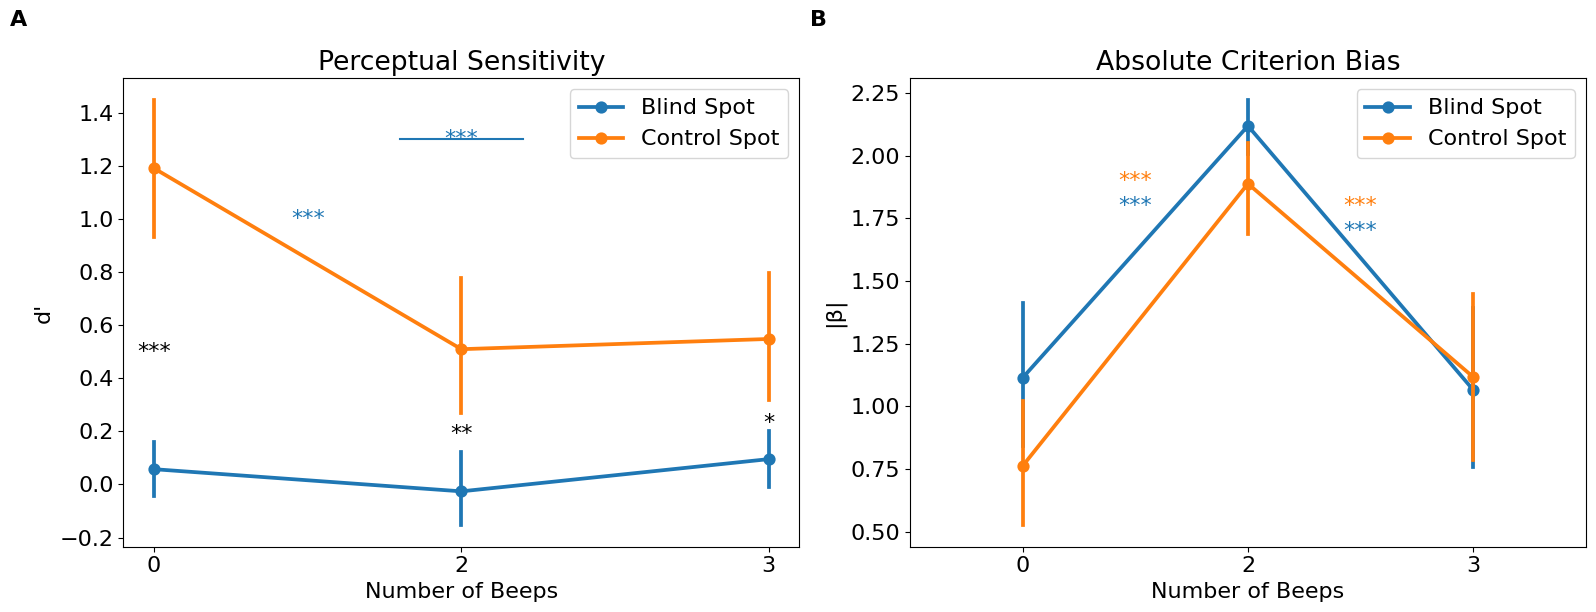

In [20]:
df_long = dprime_df.stack(level=['blindspot', 'n_beep']).reset_index(name='d_prime')
df_long.columns = ['sid', 'blindspot', 'n_beep', 'd_prime']


plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.pointplot(
    data=df_long, x="n_beep", y="d_prime", 
    hue="blindspot", ax=ax[0]
    )
palette = sns.color_palette()
colors = palette[:len(df_long["blindspot"].unique())]
ax[0].set_xlabel('Number of Beeps')
ax[0].set_ylabel("d'")
ax[0].set_title("Perceptual Sensitivity")
ax[0].legend()

################
#  Do ANOVA
################
df_long['n_beep'] = df_long['n_beep'].astype('category')
df_long['blindspot'] = df_long['blindspot'].astype('category')
model = ols('d_prime ~ n_beep * blindspot', data=df_long).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

#########################
# Tukey HSD for d_prime
#########################
tukey_dprime = pairwise_tukeyhsd(
    endog=df_long['d_prime'],  # Dependent variable
    groups=df_long['n_beep'].astype(str) + df_long['blindspot'].astype(str),  # Combine factors
    alpha=0.05
)
print("\nTukey HSD for d_prime:")
print(tukey_dprime.summary())

# between location, ***, **, *
ax[0].text(0, .5, "***", ha='center', va='center')
ax[0].text(1, .19, "**", ha='center', va='center')
ax[0].text(2, .23, "*", ha='center', va='center')

# Control, 0 vs 2, 0 vs 3, ***
ax[0].text(0.5, 1, "***", ha='center', va='center', color=colors[0])
ax[0].text(1, 1.3, "***", ha='center', va='center', color=colors[0])
ax[0].plot([.8, 1.2], [1.3, 1.3], color=colors[0])
##############################################################
# Criterion
##############################################################


df_long = beta_df.stack(level=['blindspot', 'n_beep']).reset_index(name='beta')
df_long.columns = ['sid', 'blindspot', 'n_beep', 'beta']

sns.pointplot(data=df_long, x="n_beep", y="beta", hue="blindspot", ax=ax[1])

ax[1].set_xlabel('Number of Beeps')
ax[1].set_ylabel("|β|")
ax[1].set_title("Absolute Criterion Bias")
ax[1].legend()

################
#  Do ANOVA
################
df_long['n_beep'] = df_long['n_beep'].astype('category')
df_long['blindspot'] = df_long['blindspot'].astype('category')
model = ols('beta ~ n_beep * blindspot', data=df_long).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

###############################################
# Tukey HSD for Beta (Criterion Bias)
##############################################
# Assuming `df_long` is updated for the beta_df
tukey_beta = pairwise_tukeyhsd(
    endog=df_long['beta'],  # Dependent variable
    groups=df_long['n_beep'],  # Combine factors
    alpha=0.05
)
print("\nTukey HSD for Beta:")
print(tukey_beta.summary())

ax[1].text(.5, 1.9, "***", ha='center', va='center', color=colors[1])
ax[1].text(.5, 1.8, "***", ha='center', va='center', color=colors[0])
ax[1].text(1.5, 1.8, "***", ha='center', va='center', color=colors[1])
ax[1].text(1.5, 1.7, "***", ha='center', va='center', color=colors[0])
##############################################################


plt.gcf().text(0, 1, "A", fontweight='bold',)
plt.gcf().text(0.5, 1, "B", fontweight='bold',)

plt.tight_layout()
plt.show()
